# Imports and downloads

In [302]:
import numpy as np
import pandas as pd
import warnings

In [303]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [305]:
import nltk

In [306]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [307]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [308]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.ticker as mticker

In [309]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [310]:
from IPython.display import clear_output

In [311]:
from datetime import datetime

current_time = datetime.now().strftime("%H:%M:%S")
print("Time started =", current_time)

Time started = 15:17:04


In [312]:
data = pd.read_csv("train.csv")

# EDA

In [313]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [314]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [315]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [316]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [317]:
data = data.fillna("")

## Exploring variables

### Duplicates and mislabeled data
* I'm going to check only the `text` duplicates (i.e. even though `keyword` and `location` might differ).
* A record will be considered mislabeled if it has duplicates with different `target` value 

In [318]:
data.text.duplicated(keep=False).value_counts()

False    7434
True      179
Name: text, dtype: int64

In [319]:
data[data.text.duplicated(keep=False)].target.value_counts()

1    121
0     58
Name: target, dtype: int64

In [320]:
all_dups = data[data.duplicated(subset=['text'], keep=False)].text
all_dups.nunique()

69

In [321]:
mislabeled_dups = all_dups[all_dups.apply(lambda x: data[data.text==x].target.nunique()==2)]
data.iloc[mislabeled_dups.index].sort_values(by='text')[:10]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into ...,0
4221,5996,hazardous,,#foodscare #offers2go #NestleIndia slips into ...,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into ...,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1


In [322]:
data_no_mislabeled = data.drop(mislabeled_dups.index)
data_no_duplicated = data.drop_duplicates(subset=['text'], keep=False)

In [323]:
work_data = data_no_mislabeled 

* From now on I'll work with data cleaned from mislabeled items. We'll keep duplicates for now because we assume it reflects the real structure of the twitter data. Later we'll test if it has any effect on the results to clean all the duplicates

### Helpers

In [324]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = work_data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, work_data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [325]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = work_data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [326]:
work_data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [327]:
mutual_info_score(work_data['keyword'], work_data['target']), mutual_info_score(work_data['keyword'], shuffled_target)

(0.17132360315051776, 0.01667412695998024)

* The mutual info score of this variable and the target is pretty high comparing to the "shuffled" score, so it seems the prediction significance of this variable is high

In [328]:
sorted_corr_coefs(work_data, "keyword", "target")[:10], sorted_corr_coefs(work_data, "keyword", "target")[-10:]

([('keyword=derailment', 0.08302992384814313),
  ('keyword=wreckage', 0.08302992384814298),
  ('keyword=debris', 0.08086218013088244),
  ('keyword=outbreak', 0.08040918816372149),
  ('keyword=typhoon', 0.07817379537898307),
  ('keyword=oil%20spill', 0.07817379537898284),
  ('keyword=suicide%20bombing', 0.07229181842864764),
  ('keyword=suicide%20bomber', 0.06980413608593596),
  ('keyword=rescuers', 0.06682449786303161),
  ('keyword=suicide%20bomb', 0.06682449786303152)],
 [('keyword=explode', -0.05032173057874939),
  ('keyword=wrecked', -0.05127748262122846),
  ('keyword=traumatised', -0.05128953808511176),
  ('keyword=screaming', -0.05224239029628636),
  ('keyword=electrocute', -0.05244341052765653),
  ('keyword=body%20bag', -0.05338676579344253),
  ('keyword=blazing', -0.05431426121493636),
  ('keyword=ruin', -0.057009050576103566),
  ('keyword=aftershock', -0.058308609736542324),
  ('keyword=body%20bags', -0.06042093668166045)])

* It's hard to interpret correlation coefficients at this point. Hopefully it will be more clear after experiments

### Variable "location"

In [329]:
work_data.location.value_counts()

                          2503
USA                        104
New York                    71
United States               50
London                      45
                          ... 
Paulton, England             1
SEA Server                   1
todaysbigstock.com           1
buenos aires argentina       1
Lincoln                      1
Name: location, Length: 3329, dtype: int64

In [330]:
mutual_info_score(work_data['location'], work_data['target']), mutual_info_score(work_data['location'], shuffled_target)

(0.31411093454954364, 0.30039038689558417)

* Although the score seems pretty high, it doesn't differ much from the "shuffled" score, so probably the prediction significance of this var is low

In [331]:
sorted_corr_coefs(work_data, "location", "target")[:10], sorted_corr_coefs(work_data, "location", "target")[-10:]

([('location=USA', 0.05127865597035373),
  ('location=Mumbai', 0.04740569396538076),
  ('location=India', 0.046064880856544844),
  ('location=Nigeria', 0.04390256662704054),
  ('location=Washington, DC', 0.030385934048704856),
  ('location=Nairobi-KENYA', 0.026529183512312968),
  ('location=Bend, Oregon', 0.026529183512312888),
  ('location=Calgary', 0.02652918351231286),
  ('location=MAD as Hell', 0.026529183512312843),
  ('location=Sacramento', 0.02652918351231284)],
 [('location=Texas, USA', -0.022317363198970618),
  ('location=Leeds, England', -0.022317363198970635),
  ('location=Wisconsin', -0.02231736319897064),
  ('location=Coventry', -0.022317363198970652),
  ('location=ss', -0.024218473556252923),
  ('location=London, England', -0.024218473556252926),
  ('location=Morioh, Japan', -0.024449065050066745),
  ('location=Pennsylvania, USA', -0.026409757069899925),
  ('location=304', -0.02994981634009949),
  ('location=New York', -0.04013313127058214)])

### Variable "text"

In [332]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(work_data['text'])
vectors.shape

(7558, 21612)

* We have 21612 features. There's probably lots of garbage in there. We'll clean it up with different techniques, starting with setting min_df for CountVectorizer, like this:

In [333]:
CountVectorizer(min_df=10).fit_transform(work_data['text']).shape

(7558, 1544)

* Better now! Later we'll use dimensionality reduction technique to improve it

#### Hashtags

In [334]:
hashtag_pattern = r'#(\w+)'

hashtags = work_data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=10, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['bbc', 'best', 'earthquake', 'gbbo', 'hiring', 'hiroshima', 'hot',
        'india', 'isis', 'islam', 'japan', 'job', 'jobs', 'news',
        'nowplaying', 'prebreak', 'sismo', 'terrorism', 'world', 'yyc'],
       dtype=object),
 20)

##### Additional column
Let's create another column to keep hashtags apart from the rest of vectorized tokens

In [335]:
work_data['hashtags'] = hashtags
work_data

,id,keyword,location,text,target,hashtags
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[]
7611,10872,,,Police investigating after an e-bike collided ...,1,[]


#### URLs

In [336]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [337]:
work_data.text[work_data.text.str.findall(url_pattern).apply(len) > 0].shape

(3965,)

Let's observe correlation of different words with target

In [338]:
columns = np.transpose(vectors.todense().A)

corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, work_data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [339]:
named_list[0:10], named_list[-10:]

([('http', 0.21452627610618558),
  ('co', 0.197184075655397),
  ('in', 0.1671580742879547),
  ('california', 0.1310149967949288),
  ('suicide', 0.12455801698077225),
  ('hiroshima', 0.1210916441867206),
  ('killed', 0.11979142932138698),
  ('mh370', 0.11002041366833958),
  ('wildfire', 0.10672655178990342),
  ('northern', 0.10654069392403501)],
 [('if', -0.06876362740044957),
  ('can', -0.07148314636945576),
  ('it', -0.07295391366915743),
  ('full', -0.07322194151418458),
  ('so', -0.07565381719162129),
  ('your', -0.0779455118166616),
  ('body', -0.08382709834151313),
  ('me', -0.08893371278948647),
  ('my', -0.12906704047732429),
  ('you', -0.15455528784196004)])

In [340]:
urls = work_data.text.str.lower().str.findall(url_pattern)
url_c_vect = CountVectorizer(min_df=3, analyzer=lambda x: x)
url_vectors = url_c_vect.fit_transform(urls)
url_c_vect.get_feature_names_out(), len(url_c_vect.get_feature_names_out())

(array(['http://t.co/0wratka2jl', 'http://t.co/9nwajli9cr',
        'http://t.co/bbdpnj8xsx', 'http://t.co/cedcugeuws',
        'http://t.co/cybksxhf7d', 'http://t.co/encmhz6y34',
        'http://t.co/ksawlyux02', 'http://t.co/lvlh3w3awo',
        'http://t.co/nnmqlz91o9', 'http://t.co/o91f3cyy0r',
        'http://t.co/q2eblokeve', 'http://t.co/qew4c5m1xd',
        'http://t.co/thoyhrhkfj', 'http://t.co/v3azwoamzk',
        'http://t.co/viwxy1xdyk', 'http://t.co/vvplfqv58p',
        'http://t.co/wvj39a3bgm', 'http://t.co/zujwuiomb3',
        'https://t.co/dehmym5lpk', 'https://t.co/e8dl1lncvu',
        'https://t.co/moll5vd8yd'], dtype=object),
 21)

##### Additional column
Let's create another column to keep hashtags apart from the rest of vectorized tokens

In [341]:
work_data['urls'] = urls

In [342]:
work_data

,id,keyword,location,text,target,hashtags,urls
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[],[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[],[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",[]
...,...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[],[http://t.co/stfmbbzfb5]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[],[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[],[http://t.co/zdtoyd8ebj]
7611,10872,,,Police investigating after an e-bike collided ...,1,[],[]


#### Emoji

In [343]:
import emoji

In [344]:
print(work_data.text.apply(emoji.distinct_emoji_list)[work_data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


### Target value counts

0    4313
1    3245
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7f6393d92530>,
 [Text(-0.24216139986342314, 1.0730134465216117, '0'),
  Text(0.242161399863423, -1.0730134465216117, '1')])

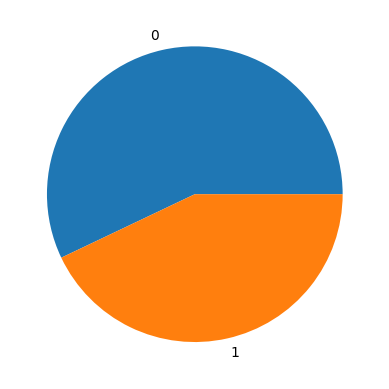

In [345]:
print(work_data.target.value_counts())
plt.pie(work_data.target.value_counts(), labels = (0,1))

* The data is somewhat imbalanced, so I need to keep an eye on using the proper settings for our models

# Training Models

## Plan

I'm going to try various data preparation and transformation steps and try them on several different classification models.
The whole pipeline will be as follows:

1. Data Preparation
    1. CountVectorizer applied to the `text` column as central part of preparation
    1. Additional steps:
        1. Cleanup URLs from text
        1. `keyword` column vectorization
        1. `location` column vectorization
        1. The newly created `hashtags` and `urls` columns vectorization
        1. Using stopwords
        1. Stemming
        1. Lemmatization
        1. ngrams
    1. By end of this stage I'll get a sparce matrix of vectors, that could be fed into different models. Testing different combinations I'll find the best steps for each model
1. Data transformation and dimensionality reduction
    1. The following techniques will be performed on the data from the previous stage:
        1. Polynomialization
        1. SelectKBest
        1. TruncatedSVD
    1. GridSearchCV will be used to find the most winning sequence
1. Final Models Parameters Tuning
    1. Each model with it's optimal data pipeline will be run through hyperparameter tuning
1. After each of the stages above I'll record the score on the test data to make possible overfitting visible

### Data Preparation Helpers and Transformers

In [346]:
from preprocess_util import k_range_scores, svd_n_range_scores, plot_k_range_results, plot_svd__range_results
from pipeline_util import make_poly2_k_best_pipeline

In [347]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

In [348]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

In [349]:
from pipeline_util import make_transformation_pipeline
def pipe_with_transformations(key):
    return make_transformation_pipeline(
        make_model(key),
        all_preparation_params[best_preparation_params[key]]
    )

In [350]:
def min_n_features(key, X=X_full_train, y=y_full_train):
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]])
    pipeline.fit(X, y)
    min_n = None
    for split in cv.split(X, y):
        n = pipeline.fit_transform(X.iloc[split[0]], y.iloc[split[0]]).shape[1]
        min_n = n if min_n is None else min(n, min_n)
            
    return min_n

### Train-Test Data Split

In [351]:
df_full_train, df_test = train_test_split(work_data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6046, 7), (1512, 7))

In [352]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target

X_test = df_test.drop('target', axis=1)
y_test = df_test.target

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

* X_full_train and y_full_train will be used for grid search and parameters tuning
* X_test and y_test will be only touched to test the tuned pipelines on different steps

In [353]:
# These data sets and cvs are used to quickly prototype a segment of data research. 
# In the end they shouldn't appear anywhere in this notebook 
small_train, small_test = train_test_split(work_data, test_size=0.9, random_state=42)
small_train.shape, small_test.shape

X_small = small_train.drop('target', axis=1)
y_small = small_train.target

cv_small_fast = [next(cv.split(X_small, y_small))]
cv_fast = [next(cv.split(X_full_train, y_full_train))]

## Data Preparation

### Steps combinations

The following preparation steps combinations were created after several iterations of the Data Preparation stage.
It would have been be too slow to test all possible combinations, so some trial and error approach was needed

In [354]:
all_preparation_params = {
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},   
    'URLs': {'urls': True},
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}, 
    'Keyword + Location': {'kw': True, 'loc': True},
    'Keyword + Hashtags': {'kw': True, 'hashtags': True},
    'Keyword + location + Hashtags': {'kw': True, 'hashtags': True, 'loc': True},
    'Keyword + Location + Stemming': {'kw': True, 
                                      'loc': True,
                                      'preprocessor': stem_preprocessor},
    'Keyword + Location + Hashtags + Stemming': {'kw': True,
                                                 'hashtags': True, 
                                                 'loc': True,
                                                 'preprocessor': stem_preprocessor}
}

### List of models

In [355]:
class Models:
    nb_key = 'Naive Bayes'
    rc_key = 'Ridge Classifier'
    lr_key = 'Logistic Regression'
    tree_key = 'Tree'
    forest_key = 'Forest'
    xgb_key = 'XGBoost'

In [356]:
# While majority of the models can handle it automatically or with a setting, XGBoost needs this to be set explicitly
scale_pos_weight = y_full_train.value_counts()[0] / y_full_train.value_counts()[1]

In [357]:
def make_model(key):
    match key:     
        case Models.nb_key:
            return ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
        case Models.rc_key:
            return RidgeClassifier(class_weight="balanced")
        case Models.lr_key:
            return LogisticRegression(class_weight="balanced", max_iter=500)
        case Models.tree_key:
            return DecisionTreeClassifier(class_weight="balanced", random_state=42)
        case Models.forest_key:
            return RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)
        case Models.xgb_key:
            return XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=0)

In [358]:
%%time
all_models_keys = [ 
        Models.nb_key, 
        Models.rc_key, 
        Models.lr_key, 
        Models.tree_key, 
        Models.forest_key, 
        Models.xgb_key
    ]

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.06 µs


In [359]:
from preprocess_util import plot_score_diffs

### Steps evaluation

In [360]:
from pipeline_util import make_preparation_pipeline

In [361]:
from sklearn.model_selection import cross_val_score

def evaluate_pipelines(pipelines, feature_key=None, with_test=True):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, pipeline in pipelines.items():
        steps = pipeline.steps.copy()
        if not any(step for step in steps if step[0] == 'classifier'):
            steps.append(('classifier', make_model(model_key)))
        clf_pipeline = Pipeline(steps)
        
        score = cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

        clf_pipeline.fit(X_full_train, y_full_train)
        record_dict[model_key] = score

        if with_test:
            test_score = f1_score(y_test, clf_pipeline.predict(X_test))
            test_record_dict[model_key] = test_score    
    
    scores_df = pd.DataFrame([record_dict])
    if with_test:
        scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [362]:
default_pipelines = {
    key: make_preparation_pipeline() for key in all_models_keys
}

In [363]:
default_scores_df = evaluate_pipelines(default_pipelines, feature_key='Default')

#### Default scores
These are scores for models with basic settings only trained on the vectorized `text` column without any preparation steps

In [364]:
default_scores_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475


In [365]:
all_preparation_pipelines = {
    key: make_preparation_pipeline(**params) for key, params in all_preparation_params.items()
}

In [366]:
def xval_pipe_with_clf(pipeline, clf):
    steps = pipeline.steps.copy()
    steps.append(('classifier', clf))
    clf_pipeline = Pipeline(steps)

    return cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

In [367]:
def xval_pipes_and_models(pipelines, models_keys):
    df = pd.DataFrame()

    for key, pipeline in pipelines.items():
        record_dict = {model_key: xval_pipe_with_clf(pipeline, make_model(model_key)) for model_key in models_keys}
        record_dict['Features'] = key
        df = pd.concat([df, pd.DataFrame([record_dict])])

    df.set_index('Features', inplace=True)
    
    return df

In [368]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    all_preparation_scores = xval_pipes_and_models(all_preparation_pipelines, all_models_keys)

CPU times: user 8min 42s, sys: 6.8 s, total: 8min 49s
Wall time: 6min 54s


#### Preparation steps effect
Here are cross-validation score differences for various preparation steps combinations against the default pipeline

In [369]:
pd.concat([all_preparation_scores, default_scores_df])

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Url Cleaner,0.738323,0.720316,0.733242,0.657123,0.716152,0.722848
Stemming,0.728849,0.721593,0.738845,0.664785,0.704046,0.733400
Lemmatization,0.713270,0.706847,0.719422,0.639835,0.676520,0.717130
Keyword,0.748595,0.723676,0.738634,0.666847,0.715289,0.733774
Location,0.731503,0.718256,0.737130,0.672442,0.700240,0.731113
Hashtags,0.734102,0.722807,0.734220,0.659374,0.704767,0.736099
URLs,0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Stopwords,0.727567,0.724085,0.733207,0.687172,0.715000,0.733127
1-2 words ngrams,0.721602,0.710679,0.733575,0.660325,0.693024,0.735004


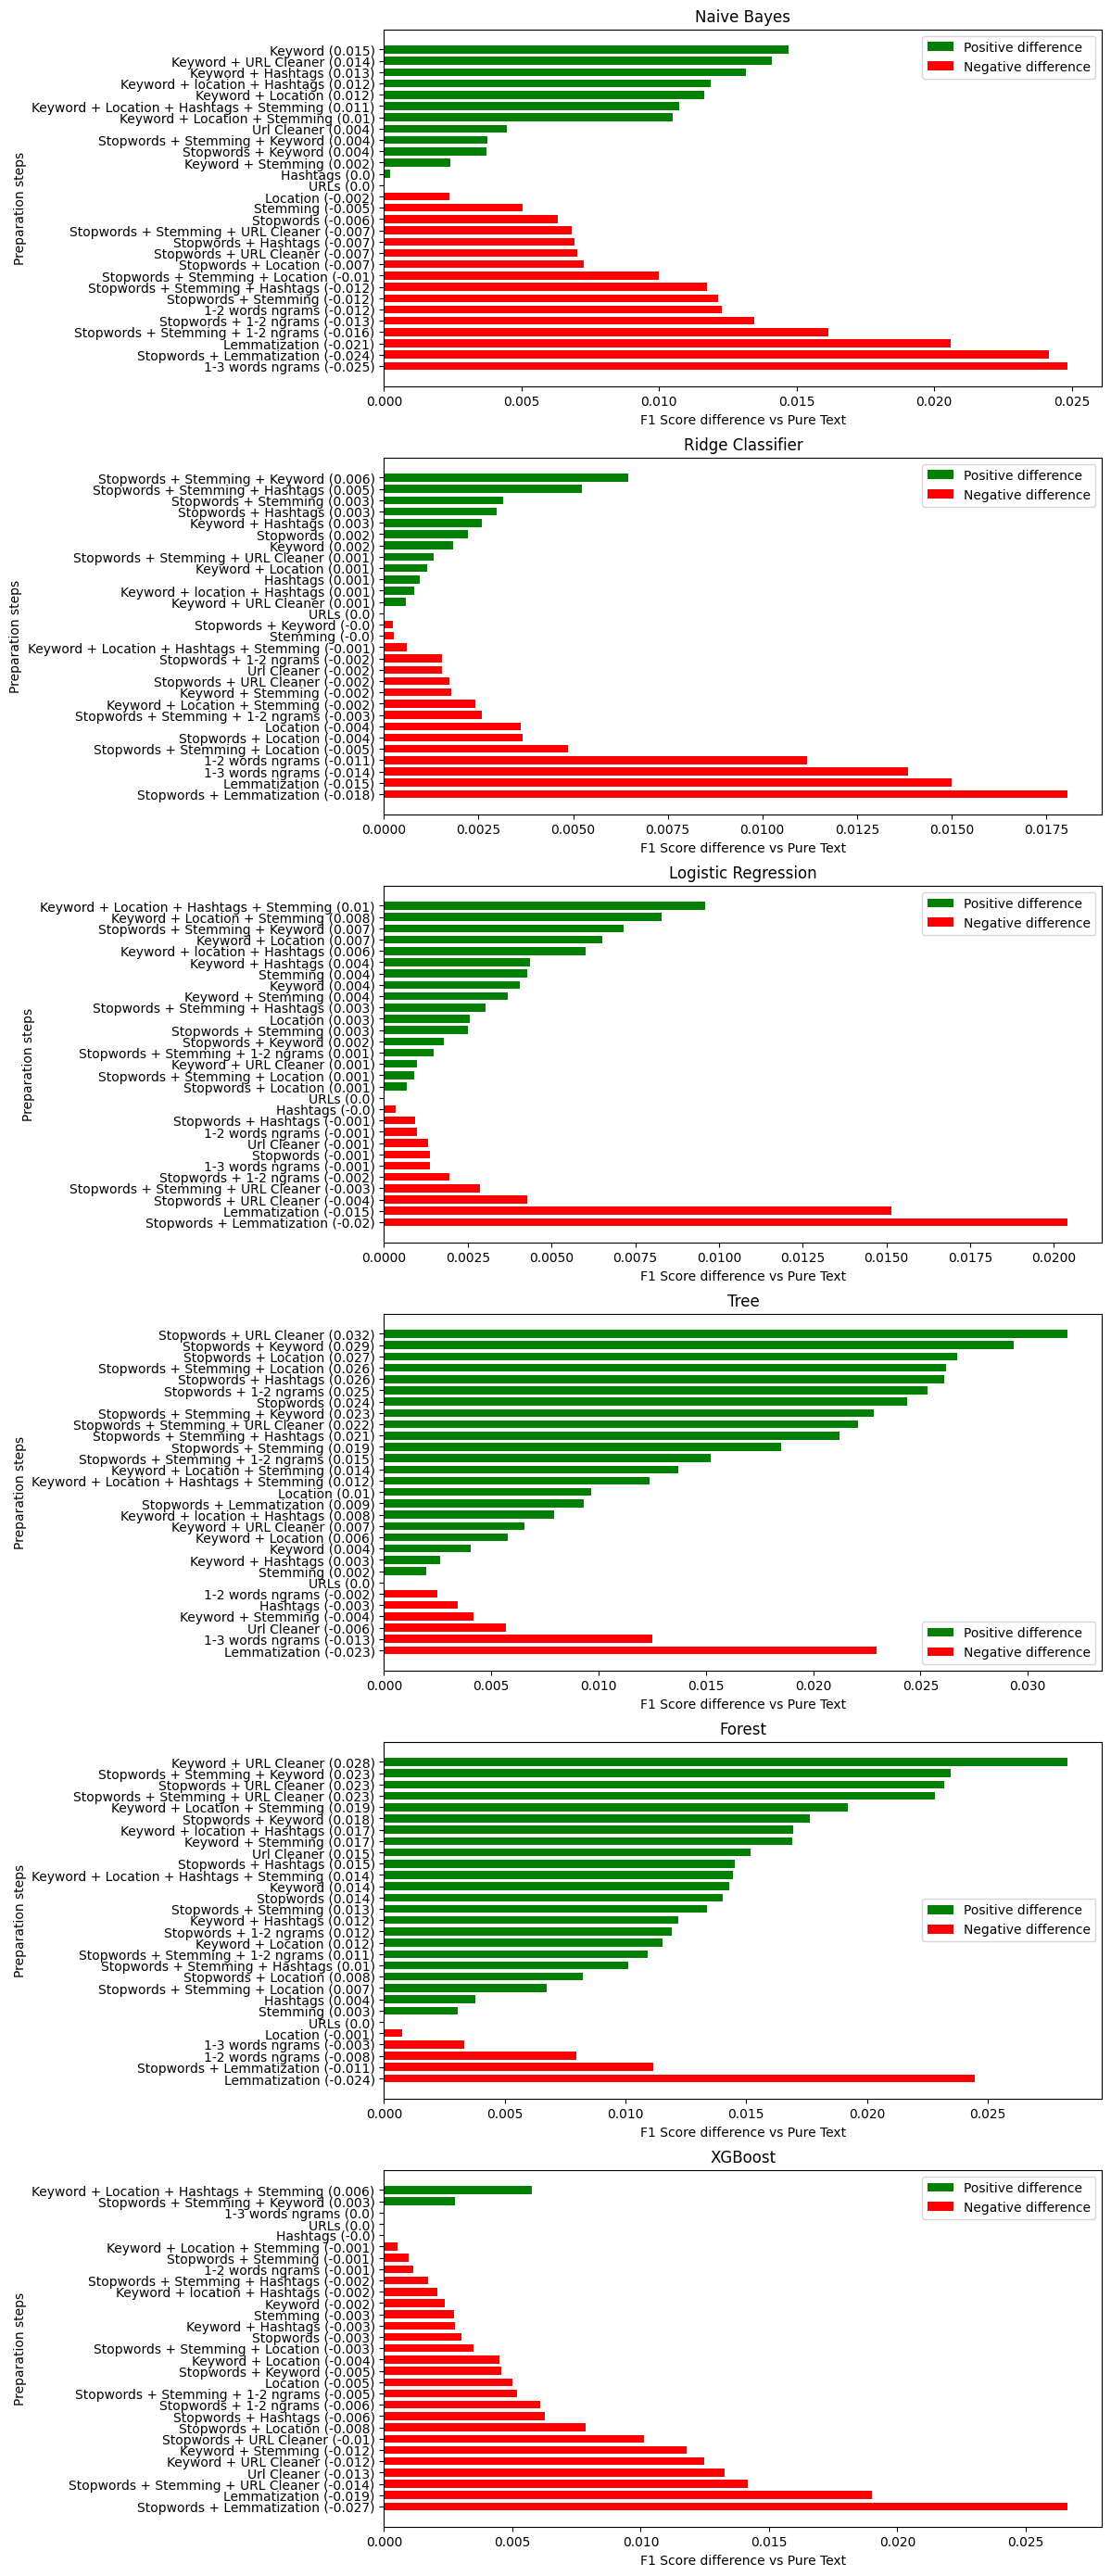

In [370]:
preparation_diffs = all_preparation_scores - default_scores_df.loc['Default (x_val)']
plot_score_diffs(preparation_diffs)

### Best preparation parameters
Some of the differences are neglectible and are obviously just fluctuations. For now I'll just blindly take the best performing combinations, but later this needs more attention

In [371]:
best_preparation_params = preparation_diffs.idxmax()
best_preparation_params

Naive Bayes                                             Keyword
Ridge Classifier                 Stopwords + Stemming + Keyword
Logistic Regression    Keyword + Location + Hashtags + Stemming
Tree                                    Stopwords + URL Cleaner
Forest                                    Keyword + URL Cleaner
XGBoost                Keyword + Location + Hashtags + Stemming
dtype: object

In [372]:
best_preparation_pipelines = {
    key: all_preparation_pipelines[params_key] for key, params_key in best_preparation_params.items()
}

### Preparation scores

In [373]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preparation_scores_df = evaluate_pipelines(best_preparation_pipelines, feature_key='Data preparation')

CPU times: user 22.4 s, sys: 346 ms, total: 22.7 s
Wall time: 14.1 s


In [374]:
pd.concat((default_scores_df, preparation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.694677,0.729309,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701700,0.740995,0.759367


### Conslusion
* There is some improvement on cross-val score for all models, and it is supported by the test score
* Hence for each model the pipeline will be based on the best preparation parameters

## Data Transformation. Polynomialization and Dimensionality Reduction

### Polynomial Features and SelectKBest with chi2 algorithm
* On this step I take the data from previous step and apply two different transformation to it:
1. Directly SelectKBest
1. First Polynomial Features and then SelectKBest on top of it
    1. The hypothesis behind using PolynomialFeatures is that some words might affect the meaning of the text in combination with the others. The idea is somewhat similar to using ngrams, but the words do not need to be placed next to each other, just to occur in the same text together
    1. The result of Polynomial Features is too high-dimensional, so it can't be used on it's own, hence we need to apply SelectKBest anyways
* Using knowledge of the number of features generated on the previous we'll build ranges for k and find the optimal values for cases with and without Polynomial Features

In [110]:
# this is helpful to create range of ks for SelectKBest transformer
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mins = {key: min_n_features(key) for key in all_models_keys}
    print(mins)

{'Naive Bayes': 1256, 'Ridge Classifier': 1128, 'Logistic Regression': 3427, 'Tree': 3063, 'Forest': 1128, 'XGBoost': 3427}


In [118]:
# these ranges where obtained after couple iterations
k_ranges_dict = {
    Models.nb_key: np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                            np.linspace(5000, 15000, 3, dtype=int))),
    Models.rc_key:  np.concatenate(
                            (np.linspace(400, 1100, 5, dtype=int),
                             np.linspace(2500, 7000, 3, dtype=int))),
    Models.lr_key:  np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 3, dtype=int))),
    Models.tree_key: np.concatenate(
                            (np.linspace(500, 1000, 5, dtype=int),
                            np.linspace(2000, 7000, 6, dtype=int))),
    Models.forest_key: np.concatenate(
                            (np.linspace(600, 1100, 6, dtype=int),
                             np.linspace(2000, 7000, 6, dtype=int))),
    Models.xgb_key: np.concatenate(
                            (np.linspace(2000, 3000, 5, dtype=int),
                            np.linspace(4000, 6000, 3, dtype=int))),
}

In [ ]:
%%time
k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        k_ranges_dict[k])  
    for k in all_models_keys
}

k_range_results = k_range_scores(k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

Started Naive Bayes at 21:21:11
Started Ridge Classifier at 21:24:26
Started Logistic Regression at 21:27:44
Started Tree at 21:57:26
Started Forest at 22:26:11
Started XGBoost at 22:31:44
CPU times: user 1h 39min 23s, sys: 2min 5s, total: 1h 41min 28s
Wall time: 1h 37min 17s


In [123]:
xgb_tree_k_ranges_dict = {
        Models.tree_key: np.concatenate(
                            (np.linspace(200, 1000, 9, dtype=int),
                            np.linspace(2000, 8000, 5, dtype=int))),    
        Models.xgb_key: np.concatenate(
                            (np.linspace(1000, 3000, 7, dtype=int),
                            np.linspace(4000, 7000, 3, dtype=int)))
}

In [124]:
%%time
xgb_tree_k_ranged_pipelines = {
    k: (pipe_with_transformations(k),
        xgb_tree_k_ranges_dict[k])  
    for k in xgb_tree_k_ranges_dict.keys()
}

xgb_tree_k_range_results = k_range_scores(xgb_tree_k_ranged_pipelines, cv=cv, X=X_full_train, y=y_full_train)

Started Tree at 23:10:31
Started XGBoost at 23:47:54
CPU times: user 1h 13min 43s, sys: 58 s, total: 1h 14min 41s
Wall time: 1h 10min 35s


In [130]:
xgb_tree_results = k_range_results.copy()
xgb_tree_results.update(xgb_tree_k_range_results)

In [116]:
# %%time
# k_ranged_pipelines = {
#     k: (pipe_with_transformations(k),
#         k_ranges_dict[k])  
#     for k in all_models_keys
# }

# k_range_results = k_range_scores(k_ranged_pipelines, cv=cv_fast, X=X_full_train, y=y_full_train)
# clear_output(wait=True)

CPU times: user 22min, sys: 27.4 s, total: 22min 27s
Wall time: 21min 30s


In [ ]:
Started Naive Bayes at 20:49:48
Started Ridge Classifier at 20:50:38
Started Logistic Regression at 20:51:30
Started Tree at 20:58:13
Started Forest at 21:03:30
Started XGBoost at 21:04:29

#### Visualization
* The Default horizontal line shows the best score right after the Data Preparation stage, i.e. without any polynomialization or dimensionality reduction 
* The range for non-poly case is limited by number of features created after the preparation stage. At the same time the poly2 case creates a huge amount of features. That's why I'm using the log scale here to display the results

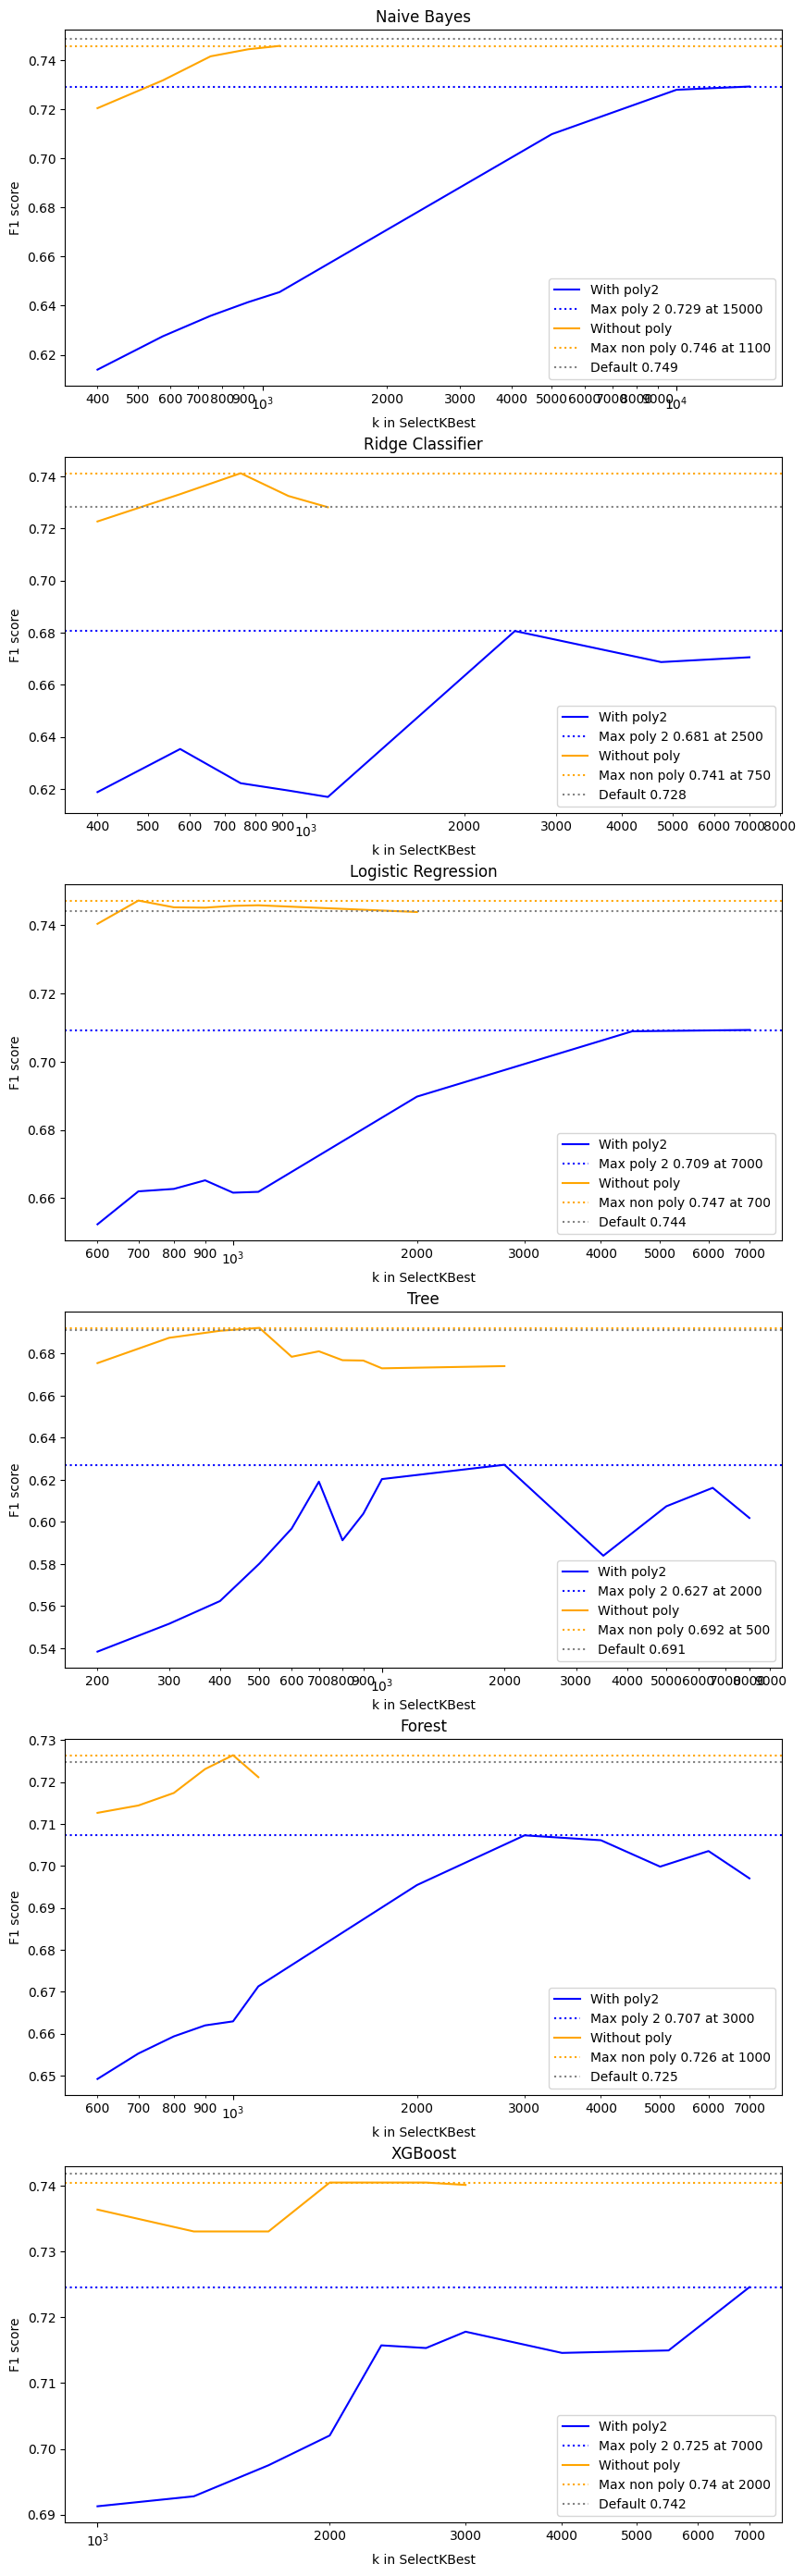

In [131]:
plot_k_range_results(xgb_tree_results)

### TruncatedSVD
* TruncatedSVD is a linear dimensionality reduction technique similar to PCA, but capable of working with sparce matrices 
* We are going to apply TruncatedSVD on the best results from the previous steps.
* The tuples below reflect the best found values for k for non-poly and poly2 cases
* There's an addition option: Poly2 + BestK 10000. The idea of adding it is to check the hypothesis that SelectBestK when set to too low k might cut some interesting features that might be picked up by TruncatedSVD  

In [135]:
%%time

best_k_dict = {
    Models.rc_key: (750, 2500),
    Models.lr_key: (700, 7000),
    Models.tree_key: (500, 2000),
    Models.forest_key: (1000, 3000),
    Models.xgb_key: (2000, 7000)
}

svd_params_dict = {
    key: {
        'pipe': pipe_with_transformations(key),
        'n_range': np.linspace(100, 1000, 10, dtype=int),
        'no_poly_k': best_k[0],
        'poly_2_k': best_k[1],
        'cv': cv,
        'X': X_full_train,
        'y': y_full_train
    } for key, best_k in best_k_dict.items()
}
    
svd_n_range_results = svd_n_range_scores(svd_params_dict)

Started Ridge Classifier at 01:05:53
Started Logistic Regression at 01:20:03
Started Tree at 02:43:25
Started Forest at 03:51:16
Started XGBoost at 04:08:51
CPU times: user 8h 5min 13s, sys: 1h 32min 37s, total: 9h 37min 51s
Wall time: 4h 44min 48s


In [153]:
all_preparation_params[best_preparation_params[Models.lr_key]]

{'kw': True, 'hashtags': True}

#### Visualization

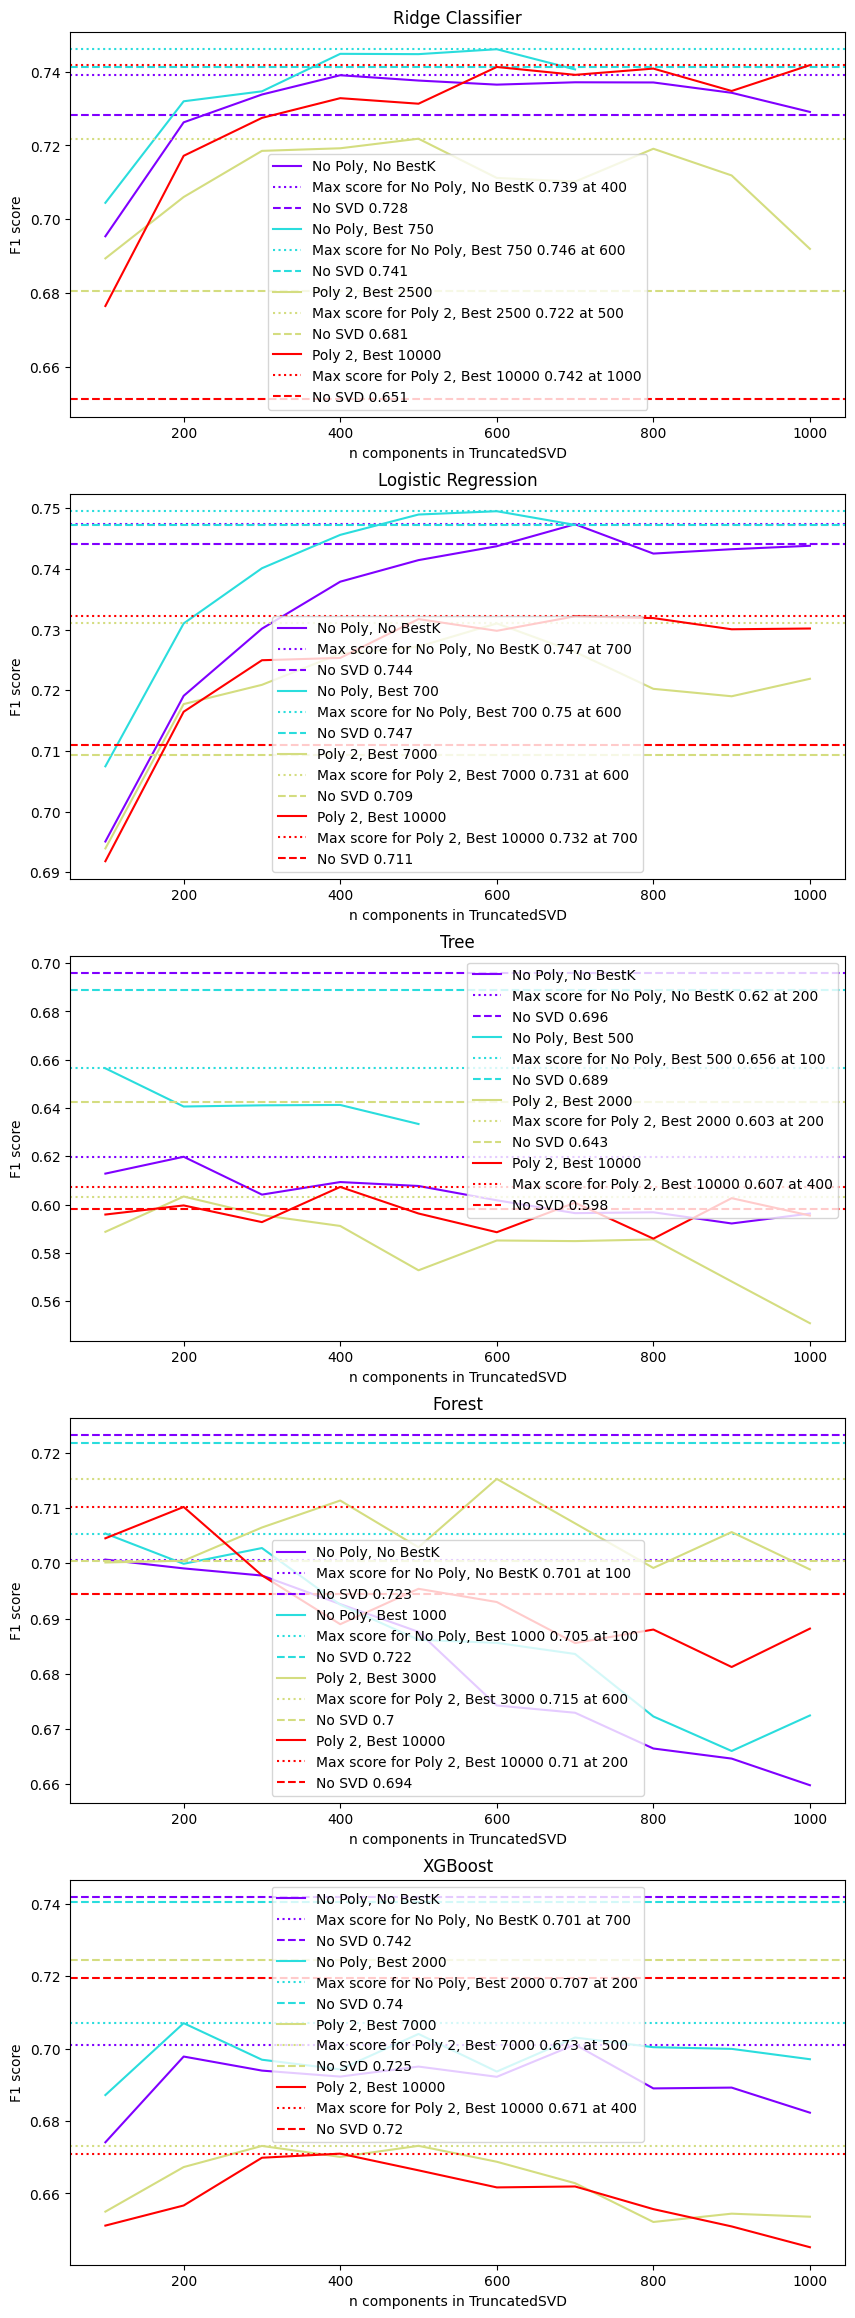

In [136]:
plot_svd__range_results(svd_n_range_results)

### Best transformation parameters and scores

In [247]:
best_transformation_params = {
    Models.nb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.rc_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 750, 'svd__n_components': 600},
    Models.lr_key: {'poly2_k_best__poly2': 'passthrough', 'poly2_k_best__k_best__k': 700, 'svd__n_components': 600},
    Models.tree_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.forest_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'},
    Models.xgb_key: {'poly2_k_best': 'passthrough', 'svd': 'passthrough'}
}

def make_best_transformation_pipeline(key):
    pipeline = pipe_with_transformations(key)

    pipeline.set_params(**(best_transformation_params[key]))
    return pipeline    

In [261]:
best_transformation_pipelines = {
    key: make_best_transformation_pipeline(key) for key in best_transformation_params.keys()
}

In [262]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    transformation_scores_df = evaluate_pipelines(best_transformation_pipelines, feature_key='Data transformation')

CPU times: user 1min 16s, sys: 54.3 s, total: 2min 11s
Wall time: 36.3 s


In [263]:
pd.concat((default_scores_df, preparation_scores_df, transformation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.657304,0.700060,0.736132
Default (test),0.760383,0.758837,0.762422,0.681388,0.725849,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.689529,0.724453,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701481,0.721615,0.759367
Data transformation (x_val),0.748595,0.745575,0.749581,0.689529,0.724453,0.741877
Data transformation (test),0.773688,0.739921,0.746057,0.701481,0.721615,0.759367


### Conclusion
* Data transformation doesn't show any positive effect neither on the Naive Bayes, nor on the Tree-Based models.
* Ther are some improvements on the cross-val score on the Linear classifiers, but the test score drops, which probably means overfitting. 
* Hence I don't take any results of the Data Transformation into the next step of the model hyperparameters tuning. I'll base it on the Data Preparation step instead

In [388]:
def make_best_preparation_pipeline(key):
    pipeline = make_preparation_pipeline(**all_preparation_params[best_preparation_params[key]])
    steps = pipeline.steps
    steps.append (('classifier', make_model(key)))
    return Pipeline(steps)

## Final Models Parameters Tuning
* The general routine will consist of consecutive steps like follows:
    * Keep best results from previous step
    * Optimize next another paramater doing search along a range of values 

In [141]:
def grid_search_fast(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv_fast) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [142]:
def grid_search(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [143]:
from preprocess_util import plot_grid_results

In [145]:
best_fine_tuning_params = {}

### Naive Bayes

Tuned Hyperparameters : {'classifier__alpha': 1.0}
F1 score : 0.7485948560615903
________________________
CPU times: user 1.91 s, sys: 1.02 ms, total: 1.91 s
Wall time: 1.91 s


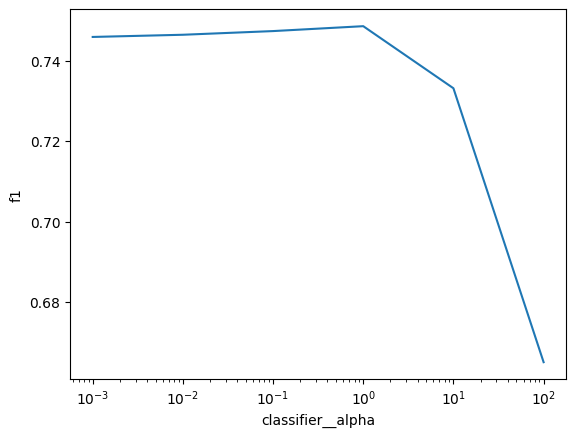

In [394]:
%%time

nb_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6)
}

nb_tuning_results = grid_search(make_best_preparation_pipeline(Models.nb_key), nb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(nb_tuning_results, 'classifier__alpha', log=True)

In [265]:
best_fine_tuning_params[Models.nb_key] = {
    'classifier__alpha': 1.0
}

### Ridge Classifier

In [266]:
best_transformation_pipelines[Models.rc_key].named_steps['classifier'].get_params()

{'alpha': 1.0,
 'class_weight': 'balanced',
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

Tuned Hyperparameters : {'classifier__alpha': 10.0, 'classifier__solver': 'lsqr'}
F1 score : 0.7421468976172007
________________________
CPU times: user 58.1 s, sys: 9.88 ms, total: 58.1 s
Wall time: 58.1 s


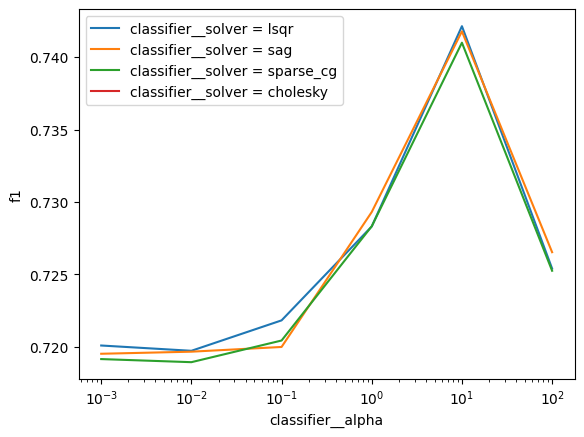

In [389]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'sag', 'sparse_cg', 'cholesky'],
}

rc_tuning_results = grid_search(make_best_preparation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver', log=True)

Tuned Hyperparameters : {'classifier__alpha': 13, 'classifier__solver': 'sag'}
F1 score : 0.7458669524698471
________________________
CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


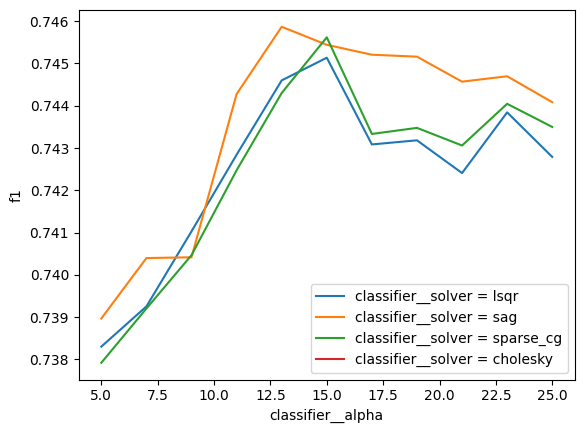

In [403]:
%%time
rc_tuning_grid = {
    'classifier__alpha': range(5, 26, 2),
    'classifier__solver': ['lsqr', 'sag', 'sparse_cg', 'cholesky'],
}

rc_tuning_results = grid_search(make_best_preparation_pipeline(Models.rc_key), rc_tuning_grid, X_full_train, y_full_train)
plot_grid_results(rc_tuning_results, 'classifier__alpha', legend_var='classifier__solver')

* The `sag` solver with alpha=14 obviously shows the best result

In [395]:
best_fine_tuning_params[Models.rc_key] = {
    'classifier__alpha': 14,
    'classifier__solver': 'sag'
}

### Logistic Regression

Tuned Hyperparameters : {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
F1 score : 0.7459217501487693
________________________
CPU times: user 53.4 s, sys: 10.4 ms, total: 53.4 s
Wall time: 53.4 s


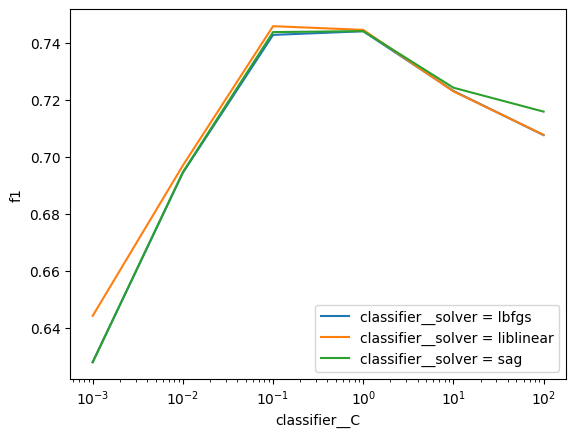

In [396]:
%%time

lr_tuning_grid = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}

lr_tuning_results = grid_search(make_best_preparation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver', log=True)

Tuned Hyperparameters : {'classifier__C': 0.25000000000000006, 'classifier__solver': 'sag'}
F1 score : 0.7517890656116558
________________________
CPU times: user 57.5 s, sys: 10.6 ms, total: 57.5 s
Wall time: 57.5 s


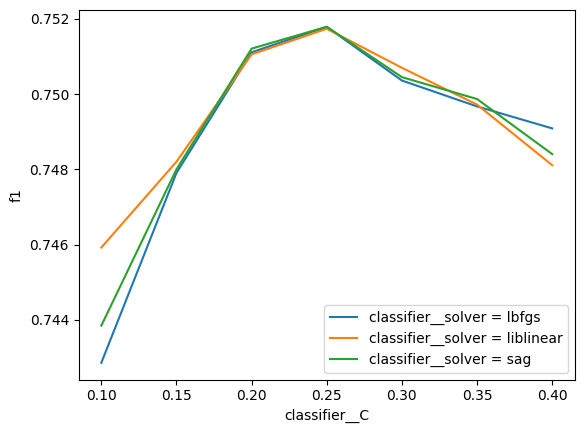

In [401]:
%%time

lr_tuning_grid = {
    'classifier__C': np.arange(0.1, 0.41, 0.05),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}

lr_tuning_results = grid_search(make_best_preparation_pipeline(Models.lr_key), lr_tuning_grid, X_full_train, y_full_train)
plot_grid_results(lr_tuning_results, 'classifier__C', legend_var='classifier__solver')

* Solver seems to make no difference, so the default `lbgfs` is ok, so only the `C` (regularization strength) parameter goes to the params dict

In [404]:
best_fine_tuning_params[Models.lr_key] = {
    'classifier__C': 0.25
}

### Decision Tree

In [275]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 3, 5, 10, 20, 50, 100, 120, 130, 140, 150, 170, 200, 300, None]
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 120}
F1 score : 0.6983741312591352
________________________
CPU times: user 21.6 s, sys: 0 ns, total: 21.6 s
Wall time: 21.6 s


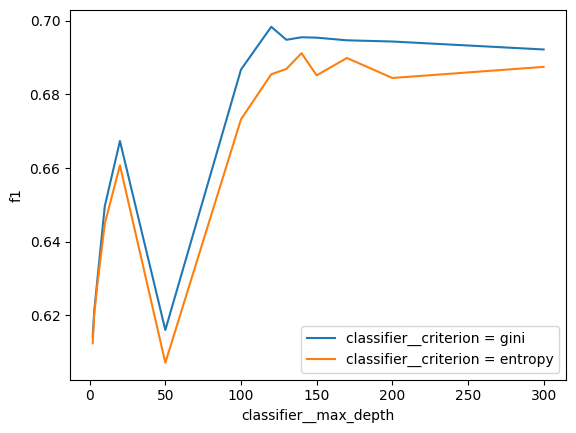

In [276]:
plot_grid_results(tree_tuning_results, 'classifier__max_depth', legend_var='classifier__criterion')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 120, 'classifier__min_samples_leaf': 1}
F1 score : 0.6983741312591352
________________________
CPU times: user 46.1 s, sys: 4.89 ms, total: 46.1 s
Wall time: 46.1 s


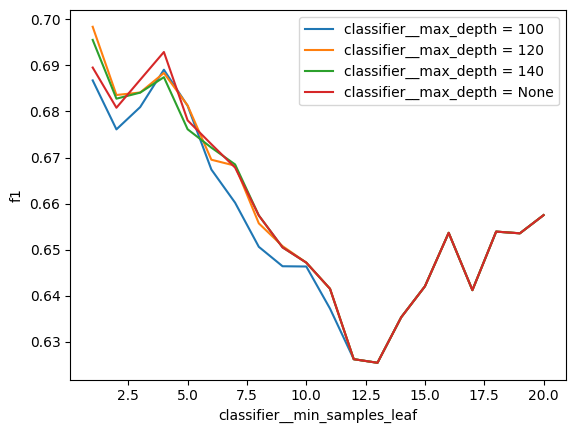

In [277]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [100, 120, 140, None],
    'classifier__min_samples_leaf': np.linspace(1, 20, 20, dtype=int)
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_leaf', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 140, 'classifier__min_samples_split': 70}
F1 score : 0.7121183160257943
________________________
CPU times: user 55.5 s, sys: 0 ns, total: 55.5 s
Wall time: 55.5 s


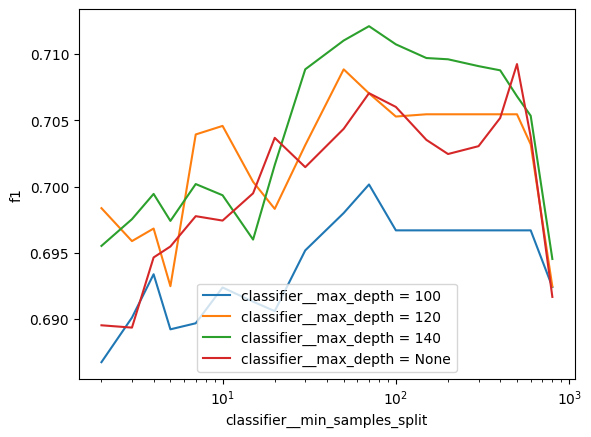

In [278]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [100, 120, 140, None],
    'classifier__min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 800]
}

tree_tuning_results = grid_search(make_best_preparation_pipeline(Models.tree_key), tree_tuning_grid, X_full_train, y_full_train)
plot_grid_results(tree_tuning_results, 'classifier__min_samples_split', legend_var='classifier__max_depth', log=True)

In [280]:
best_fine_tuning_params[Models.tree_key] = {
    'classifier__criterion': 'gini',
    'classifier__max_depth': 140,
    'classifier__min_samples_split': 70
}

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__n_estimators': 130}
F1 score : 0.7336777019733399
________________________
CPU times: user 6min 12s, sys: 23.4 s, total: 6min 36s
Wall time: 8min 6s


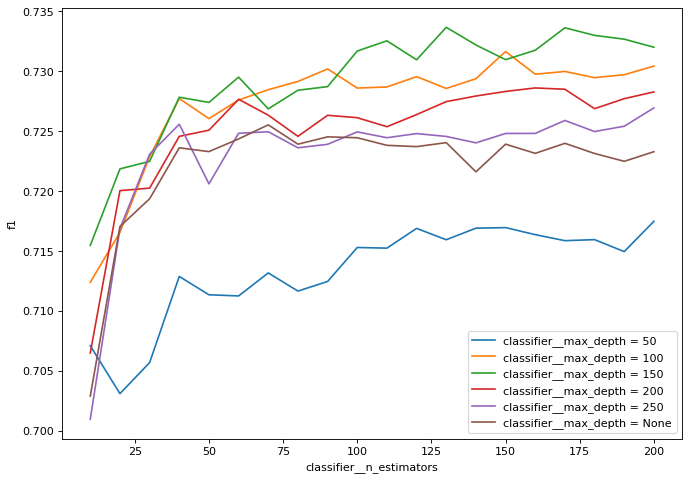

In [281]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [50, 100, 150, 200, 250, None],
    'classifier__n_estimators': np.linspace(10, 200, 20, dtype=int)
}

forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__n_estimators': 220}
F1 score : 0.7408281697171093
________________________
CPU times: user 4min 12s, sys: 20.1 s, total: 4min 32s
Wall time: 6min


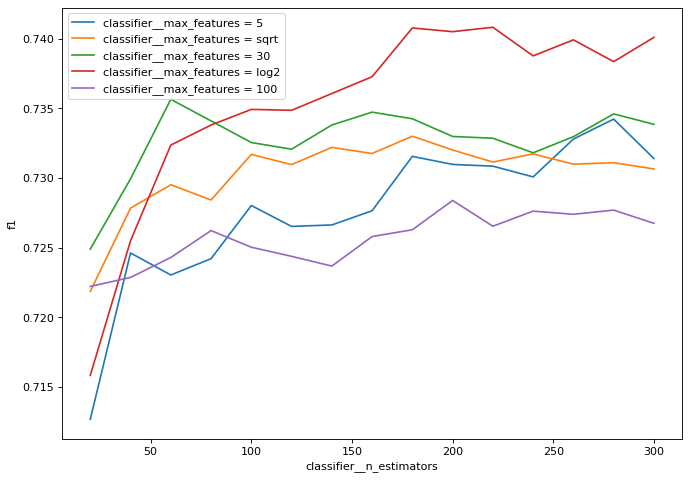

In [282]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': [5, 'sqrt', 30, 'log2', 100],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_features')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200}
F1 score : 0.7558449131779494
________________________
CPU times: user 5min 46s, sys: 35.3 s, total: 6min 21s
Wall time: 6min 37s


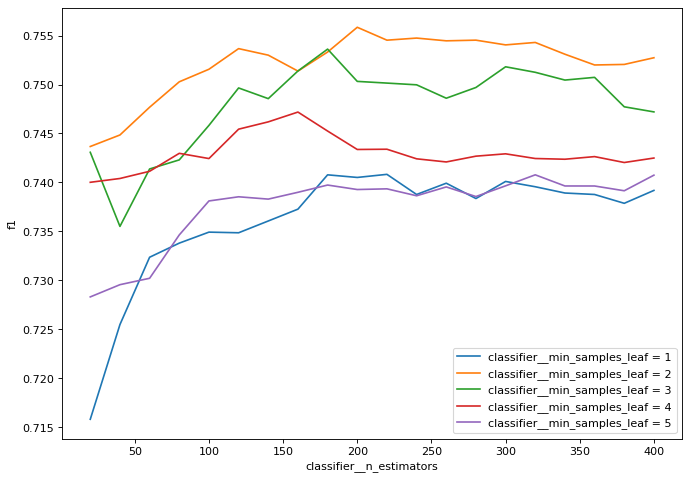

In [283]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__n_estimators': np.linspace(20, 400, 20, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_leaf')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 500, 'classifier__n_estimators': 150}
F1 score : 0.7526435349362199
________________________
CPU times: user 1min 39s, sys: 8.48 s, total: 1min 47s
Wall time: 1min 46s


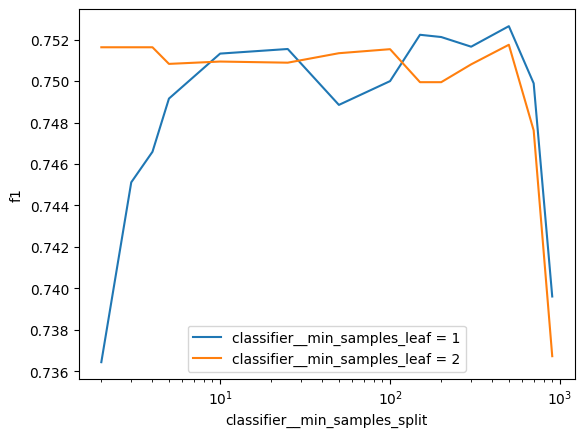

In [284]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1, 2],

    'classifier__min_samples_split': [2, 3, 4, 5, 10, 25, 50, 100, 150, 200, 300, 500, 700, 900],
    'classifier__n_estimators': [150]
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
plot_grid_results(forest_tuning_results, 'classifier__min_samples_split', legend_var='classifier__min_samples_leaf', log=True)

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
F1 score : 0.7558449131779494
________________________
CPU times: user 2min 23s, sys: 12.9 s, total: 2min 36s
Wall time: 2min 31s


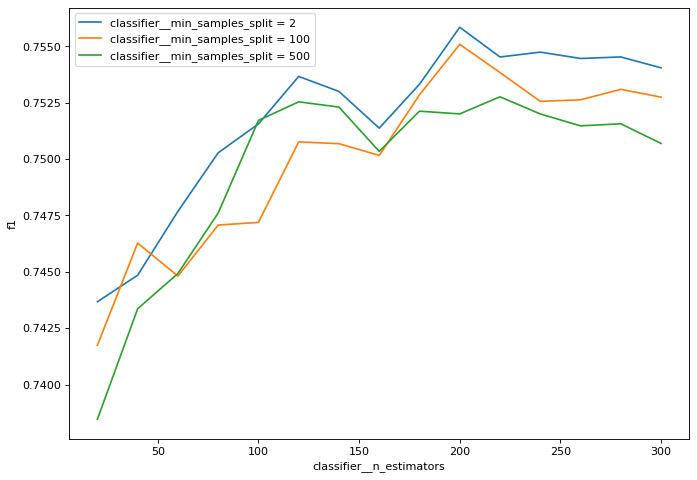

In [285]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [2],
    'classifier__min_samples_split': [2, 100, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

Tuned Hyperparameters : {'classifier__max_depth': 150, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 280}
F1 score : 0.7547712988442532
________________________
CPU times: user 2min 29s, sys: 13.7 s, total: 2min 42s
Wall time: 2min 36s


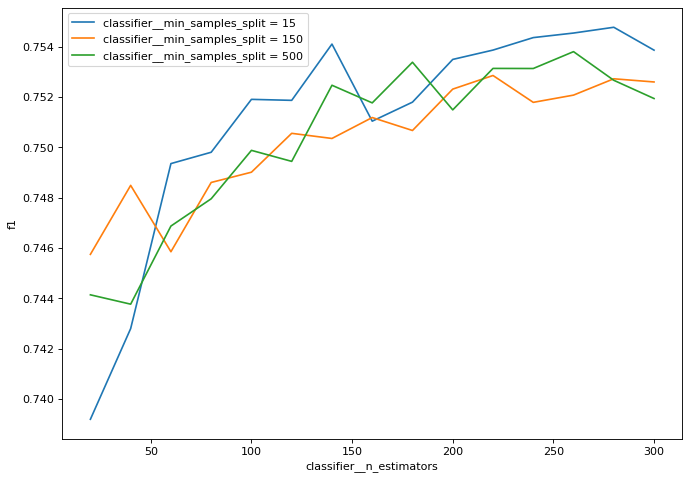

In [286]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [150],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_leaf': [1],
    'classifier__min_samples_split': [15, 150, 500],
    'classifier__n_estimators': np.linspace(20, 300, 15, dtype=int)
}


forest_tuning_results = grid_search(make_best_preparation_pipeline(Models.forest_key), forest_tuning_grid, X_full_train, y_full_train)
figure(figsize=(10, 7), dpi=80)
plot_grid_results(forest_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_samples_split')

In [288]:
best_fine_tuning_params[Models.forest_key] =  {
    'classifier__max_depth': 150,
    'classifier__max_features': 'log2',
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 15,
    'classifier__n_estimators': 280
}

### XGBoost

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 12min 36s, sys: 2.52 s, total: 12min 38s
Wall time: 3min 37s


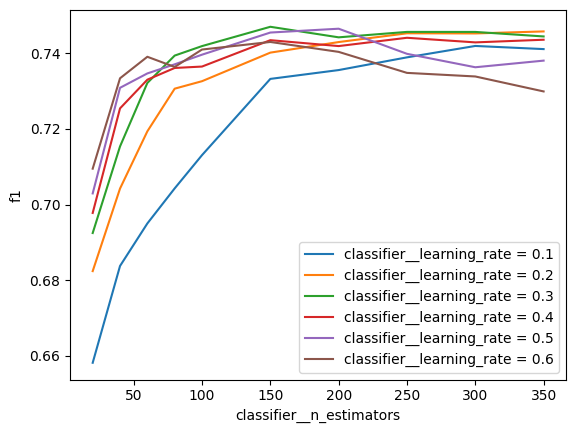

In [287]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__learning_rate')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 13min 17s, sys: 3.44 s, total: 13min 20s
Wall time: 3min 46s


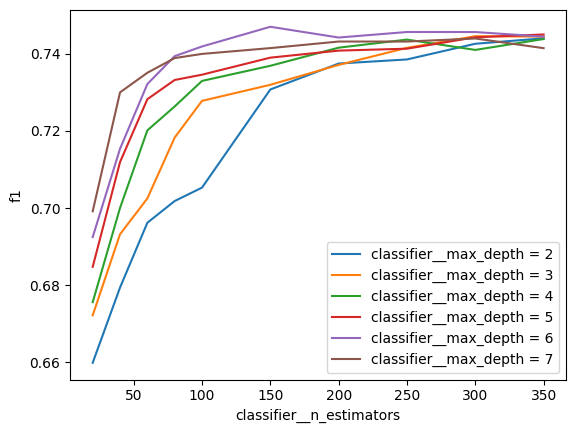

In [289]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7]
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__max_depth')

Tuned Hyperparameters : {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 150}
F1 score : 0.7469810572257779
________________________
CPU times: user 8min 9s, sys: 1.55 s, total: 8min 10s
Wall time: 2min 22s


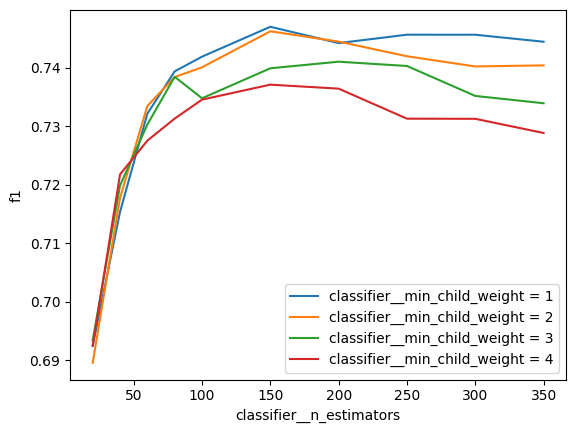

In [290]:
%%time

xgb_tuning_grid = {
    'classifier__n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int), 
                                           np.linspace(150, 350, 5, dtype=int))),    
    'classifier__learning_rate': [0.3],
    'classifier__max_depth': [6],
    'classifier__min_child_weight': [1, 2, 3, 4]
}

xgb_tuning_results = grid_search(make_best_preparation_pipeline(Models.xgb_key), xgb_tuning_grid, X_full_train, y_full_train)
plot_grid_results(xgb_tuning_results, 'classifier__n_estimators', legend_var='classifier__min_child_weight')

In [291]:
best_fine_tuning_params[Models.xgb_key] = {
    'classifier__n_estimators': 150,    
    'classifier__learning_rate': 0.3,
    'classifier__max_depth': 6,
    'classifier__min_child_weight': 1
}

### Best fine tuning score

In [405]:
def make_best_fine_tuned_pipeline(key):
    pipeline = make_best_preparation_pipeline(key)

    pipeline.set_params(**(best_fine_tuning_params[key]))
    return pipeline    

In [406]:
best_fine_tuning_pipelines = {
    key: make_best_fine_tuned_pipeline(key) for key in best_fine_tuning_params.keys()
}

In [407]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fine_tuning_scores_df = evaluate_pipelines(best_fine_tuning_pipelines, feature_key='Fine tuning')

CPU times: user 25.9 s, sys: 1.48 s, total: 27.4 s
Wall time: 16.1 s


In [408]:
pd.concat((default_scores_df, preparation_scores_df, fine_tuning_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Default (x_val),0.733873,0.721860,0.734567,0.662804,0.700984,0.736132
Default (test),0.760383,0.758837,0.762422,0.669298,0.727909,0.742475
Data preparation (x_val),0.748595,0.728327,0.744144,0.694677,0.729309,0.741877
Data preparation (test),0.773688,0.762805,0.767677,0.701700,0.740995,0.759367
Fine tuning (x_val),0.748595,0.746462,0.751787,0.722283,0.745691,0.746981
Fine tuning (test),0.773688,0.757576,0.773481,0.740854,0.760684,0.767213


# Observations and conclusions

In [409]:
best_preparation_params

Naive Bayes                                             Keyword
Ridge Classifier                 Stopwords + Stemming + Keyword
Logistic Regression    Keyword + Location + Hashtags + Stemming
Tree                                    Stopwords + URL Cleaner
Forest                                    Keyword + URL Cleaner
XGBoost                Keyword + Location + Hashtags + Stemming
dtype: object

## All Models
* It's worth noting that the test scores are everywhere significantly better than the cross-val score. It probably can be explained by the fact that test score is measured with a model trained on the whole full train set, while for cross-val only the part of it is used, which is 75% in this case
    * It may indicate that the results will be improved with growth of the training data set

### Naive Bayes
* Data preparation: `
    * keyword` column
* Data transformation:
    * SelectKBest had no improvement on the score. Almost achieved the default score when `k` approached to the number of generated features. Which was obviously expected
    * The SVD was not applicable, since Naive Bayes works with integer frequencies
* Model parameter tuning: 
    * resulted in default parameters
* Overall performance:
    * While utilizing the least of data preparation and transformation steps among classifiers, it showed the best results across all the stages right after the Preparation Stage
    

### Linear Classifiers (Ridge Classifier and Logistic Regression)
* Data preparation:
    * RC: `Stopwords + Stemming + Keyword`
    * LR: `Keyword + Location + Hashtags + Stemming`
    * For both models the preparation shows some growth around ~1% score, demonstrated by both x-val and test values, so probably it's somewhat trustworthy
* Data transformation:
    * RC: No Polynomialization, SelectKBest with k=750, TruncatedSVD with 600 components
    * LR: Keyword + Location + Hashtags + Stemming
    * Both models showed some growth on cross-val score, but at the same time the test score dropped quite significantly. 
        * The reason is probably overfitting
* Model parameter tuning:
    * RC: after regularization strength tuning showed some growth on cross-val score. At the same time there was a slight (~0.5%) drop in the test score which might indicate slight overfitting, but I thing it's rather a fluctuation
    * LR: proven growth

### Tree-based Classifiers (Decision Tree, Random Forest and XGBoost)
* Data preparation:
    * Tree: `Stopwords + URL Cleaner`
    * Forest: `Keyword + URL Cleaner`
    * XGBoost: `Keyword + Location + Hashtags + Stemming`
    
* Data transformation:
    * On all the Tree-based classifiers:
        * SelectKBest: no improve
        * PolynomialFeatures: significant drop
        * TruncatedSVD: significant drop
    * Interpretation:
        * Both PolynomialFeatures and TruncatedSVD are meant either to improve data representation (remove noise or add hidden patterns in linear space. Since Tree-Based models do not operate in linear space, this is of no use for them
        * SelectKBest seems to be able to bring some value, but probably we need a bigger dataset with more features after vectorization
* Model parameter tuning:
    * All Tree-based Classifiers showed very nice growth on both cross-val and test values

##  General Conclusion
* The Naive Bayes seems to work the best among the models on data like twitters
* The fact that all models, despite being tuned in different ways, converge to a similar mean score (~76-77%) in the end, might indicate that this value is close to the limit of the sentiment information this data contains
    * This possibly can be improved by bringing more information for example with pretrained embeddings

## Next steps 

* Try other techniques
    * Pretrained embeddings. It can happen that finding synonyms within data and encoding them as the same token will improve the predicting power of our models
    * Train a neural network, preferably CNN
* Try more preparation steps, such as:
    * complete deduplication at the preparation stage
    * trying different min_df for the vectorizers
    * regrouping transformers inside the pipelines 